In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cpyment import CModel

A test based on the model outlined and parametrised in the preprint [Expected impact of lockdown in Île-de-France and possible exit strategies](https://doi.org/10.1101/2020.04.13.20063933).

In [3]:
# States:
#
# Susceptible
# Exposed
# Infectious, prodromic phase
# Infected, asymptomatic
# Infected, paucisymptomatic
# Infected, mild symptoms
# Infected, severe symptoms
# Hospitalised
# ICU admission
# Recovered
# Dead

states = ['S', 'E', 'Ip', 'Ia', 'Ips', 'Ims', 'Iss', 'H', 'ICU', 'R', 'D']

In [4]:
# Parameters, times are in days. All variables are taken for adults here

th = 1.0/5.2            # Incubation period
mu_p = 1.0/1.5          # Prodromal phase
eps = 1.0/(1/th-1/mu_p) # Latency period
p_a = 0.2               # Probability of being asymptomatic (adults)
p_ps = 0.2              # Probability of being paucisymptomatic (if symptomatic, adults)
p_ms = 0.7              # Probability of having mild symptoms (if symptomatic, adults)
p_ss = 0.1              # Probability of having severe symptoms (if symptomatic, adults)
s = 7.5                 # Serial interval
mu = 1.0/(s-1/th)       # Infectious period
r_beta = 0.51           # Relative infectiousness of Ip, Ia, Ips
p_ICU = 0.36            # Probability of going in ICU for Iss (adults)
lambda_HR = 0.072       # Daily rate of recovery from hospitalized
lambda_HD = 0.042       # Daily mortality from hospitalized
lambda_ICUR = 0.05      # Daily rate of recovery from ICU
lambda_ICUD = 0.0074    # Daily mortality from ICU

contact = 7.0           # Estimated adult-adult contact rate

Now to build the model.

![alt text](idf_fig2.png "Figure 2")

(figure from L. Di Domenico et al., [Expected impact of lockdown in Île-de-France and possible exit strategies](https://doi.org/10.1101/2020.04.13.20063933) )

In [5]:
cm = CModel(states)

# Infection processes
cm.set_coupling_rate('S*Ip:S=>E', r_beta*contact, "beta_Ip")
cm.set_coupling_rate('S*Ia:S=>E', r_beta*contact, "beta_Ia")
cm.set_coupling_rate('S*Ips:S=>E', r_beta*contact, "beta_Ips")
cm.set_coupling_rate('S*Ims:S=>E', contact, "beta_Ips")
cm.set_coupling_rate('S*Iss:S=>E', contact, "beta_Ips")

# Evolution of the disease
cm.set_coupling_rate('E:E=>Ip', eps, "gamma_E")
cm.set_coupling_rate('Ip:Ip=>Ia', mu_p*p_a, "gamma_Ip_Ia")
cm.set_coupling_rate('Ip:Ip=>Ips', mu_p*(1-p_a)*p_ps, "gamma_Ip_Ips")
cm.set_coupling_rate('Ip:Ip=>Ims', mu_p*(1-p_a)*p_ms, "gamma_Ip_Ims")
cm.set_coupling_rate('Ip:Ip=>Iss', mu_p*(1-p_a)*p_ss, "gamma_Ip_Iss")

# Hospitalisation
cm.set_coupling_rate('Iss:Iss=>H', mu*(1-p_ICU), "gamma_Iss_H")
cm.set_coupling_rate('Iss:Iss=>ICU', mu*p_ICU, "gamma_Iss_ICU")

# Recovery
cm.set_coupling_rate('Ia:Ia=>R', mu, "gamma_Ia_R")
cm.set_coupling_rate('Ips:Ips=>R', mu, "gamma_Ips_R")
cm.set_coupling_rate('Ims:Ims=>R', mu, "gamma_Ims_R")
cm.set_coupling_rate('H:H=>R', lambda_HR, "gamma_H_R")
cm.set_coupling_rate('ICU:ICU=>R', lambda_ICUR, "gamma_ICU_R")

# Death
cm.set_coupling_rate('H:H=>D', lambda_HD, "gamma_H_D")
cm.set_coupling_rate('ICU:ICU=>D', lambda_ICUD, "gamma_ICU_D")

In [8]:
# Integrate the equations in percentages
N = 1.0
N_E = 0.001

y0 = np.zeros(len(states))
y0[0] = N-N_E
y0[1] = N_E

t = np.linspace(0, 60, 1000) # Two months

traj = cm.integrate(t, y0)

In [13]:
# Statistics

print('Final deaths: {0:.2f}%'.format(traj['y'][-1,-1]*100))
print('Peak ICU use: {0:.2f}%'.format(np.amax(traj['y'][:,-3])*100))
print('Peak hospitalisation: {0:.2f}%'.format(np.amax(traj['y'][:,-4])*100))

Final deaths: 2.21%
Peak ICU use: 1.74%
Peak hospitalisation: 2.34%


<IPython.core.display.Javascript object>


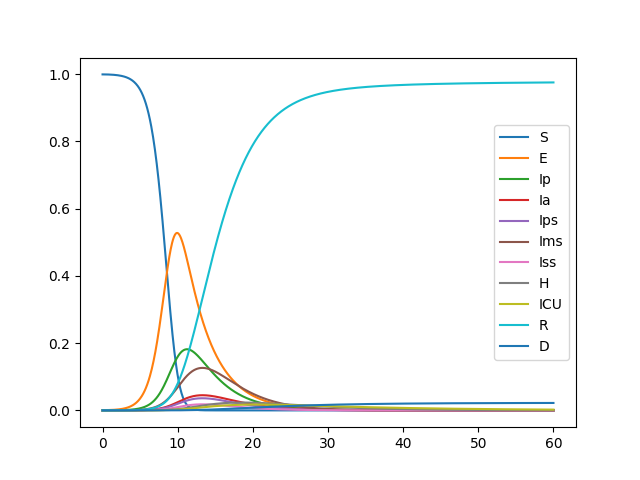

In [14]:
fig, ax = plt.subplots()

for i, s in enumerate(states):
    ax.plot(t, traj['y'][:,i],label=s)
    
ax.legend()